# Load fundamental modules & initialize variables

In [1]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py
import warnings
from importlib import reload

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import warnings
warnings.filterwarnings( 'ignore' )
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# Plotting parameters
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42
# warnings.filterwarnings( 'default' )

# Personal - for code, not data.
sys.path.append('/home1/cjmac/code/general')
sys.path.append('/home1/cjmac/code/manning_replication')
sys.path.append('/home1/cjmac/code/projects/')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2

from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
font = {'tick': 12,
        'label': 14,
        'fig': 16}

## Perform alignment (or not)

In [2]:
subj_sess = 'U540_ses0'

# Load the sync channel.
# sync_chan = events_preproc.load_syncs(subj_sess, data_key='data')
sync_chan, TTL, timestamp_flag = events_preproc.load_syncs(subj_sess, data_key='data')

if not timestamp_flag: 
     
    # Read events file and get event synctimes.
    events, event_synctimes = events_preproc.read_events_json( subj_sess )

    # Load LFP timestamps. LFP timestamps must be in msec
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps( subj_sess )

    # Identify sync pulses in the sync channel EEG. The sync channel EEG is typically sampled at a different rate than the physiological EEG.
    pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                       sampling_rate=sr, 
                                                       pulse_thresh=200, 
                                                       intrapulse_thresh_ms=20, 
                                                       interpulse_thresh_ms=790
                                                      )
    
    lfp_synctimes = lfp_timestamps[pulse_startinds]
    
    print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

    subj, sess = subj_sess.split('_')
    sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')


    # Find matching sync pulse pairs.
    event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                             lfp_synctimes, 
                                                                             step=5, 
                                                                             max_shift=200, 
                                                                             max_slide=50, 
                                                                             ipi_thresh=2
                                                                            )
    # Perform the alignment.
    alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                                 lfp_synctimes_adj)
    
    # Apply the alignment to all event times.
    events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))    
    
    plot_flag = 0     
    if (plot_flag):
        # How did our alignment go?
        print('{} event sync pulses'.format(len(event_synctimes_adj)))
        print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
        print('\n--------------------\nAlignment parameters\n--------------------')
        for k, v in alignment.items():
            print('{}: {}'.format(k, v))

        plt.close()
        fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
        ax = np.ravel(ax)

        min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
        start = 0
        stop = None

        i = 0
        ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
        ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
        ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
        ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

        i = 1
        ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
        ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
        ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
        ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
        ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

        i = 2
        ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
        ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
        ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
        ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

        for i in range(len(ax)):
            ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
        fig.tight_layout()

        event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
        event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                                      if x<len(lfp_timestamps)])).astype(np.int64)
        event_pulse_startinds_train = np.zeros(len(sync_chan))
        event_pulse_startinds_train[event_pulse_inds] = 1

        fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                              start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)  
else:    
    # Read events file and get event synctimes in msec.
    events, event_synctimes = events_preproc.read_events_json( subj_sess, start_at_zero = False  )
    
    # Load LFP timestamps in msec
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps( subj_sess, start_at_zero = True, conv_factor = 'infer' )

    if (False):
        #
        sync_chan_new = sync_chan.copy()
        sync_chan_new *= 1000 ; # converts to msec
        sync_chan_new = sync_chan_new - sync_chan_new[0] #sync_chan_new and sync_chan are shorter in length than lfp_timestamps bc of different sampling frequency
        TTL_new = TTL.copy()
        TTL_new[np.where(TTL != 255)] = 0
        from scipy import interpolate
        f = interpolate.interp1d(sync_chan_new, TTL_new, kind = 'next', fill_value='extrapolate')
        TTL_up = f(lfp_timestamps)

        plot_flag = 0
        if plot_flag:
            ind_range_1 = [ 0, 100000 ] 
            fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=300)
            plt.plot(lfp_timestamps[ slice( ind_range_1[0], ind_range_1[1], 1)], 
                     TTL_up[ slice( ind_range_1[0], ind_range_1[1], 1)],
                     marker = 'o', color = 'blue', linestyle = 'none', markersize = 8 )

        pulse_startinds = np.where(TTL_up == 255)[0] 
        lfp_synctimes = lfp_timestamps[pulse_startinds]
        
        # 
        plot_flag = 0
        if plot_flag:
            time_range = [ 30000, 100000 ] 
            ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
            ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
            fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
            plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
                     np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
                     marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
            plt.plot(event_synctimes[ ind_event_synctimes ], 
                     np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
                     marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
            plt.show()   
    
    else:
        #
        sync_chan_new = sync_chan.copy()
        sync_chan_new /= 1000  # converts to msec
#         sync_chan_new = sync_chan_new - sync_chan_new[0] # zero the timestamps
        TTL_up = TTL.copy()
        pulse_startinds = np.where(TTL_up == 1)[0] 
        lfp_synctimes = sync_chan_new[pulse_startinds]
        event_synctimes = event_synctimes[2000:]

The first timestamp in events before zero-ing is 1627593194100.360
The first timestamp in events after zero-ing is 0.000
85458 events recorded over 68 min and 52 sec
The first timestamp in lfp_timestamps before zero-ing & before conv factor is 0.000
The first timestamp in lfp_timestamps before zero-ing & after conv factor is 0.000
The first timestamp in lfp_timestamps after zero-ing & conv factor is 0.000
Conversion factor is 1
123945508 timestamps over 68 min and 51.5 s
Sampling rate is 30000 Hz
Detected 4098 EEG sync pulses
Detected 4098 syncs for 4131 sync pulse events
Retained 3940 sync pulses


In [3]:
plot_flag = 0
if plot_flag:
    time_range = [ 30000, 100000 ] 
    ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
    ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
    fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
    plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
             np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
             marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
    plt.plot(event_synctimes[ ind_event_synctimes ], 
             np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
             marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
    plt.show()  
    
# need a way to check (a) if time is in UNIX time or ? AND (b) if UNIX time is in us, ms, or s.

plot_flag = 0
# Creating histogram
if plot_flag:
    fig, ax = plt.subplots(figsize=[8, 8], sharex = 'col', sharey = 'row')
    ax = plt.subplot(2, 1, 1)
    ax.hist(np.diff(event_synctimes), bins = range(0, 2000, 10))
    ax = plt.subplot(2, 1, 2)
    ax.hist(np.diff(lfp_synctimes), bins = range(0, 2000, 10))   
    
# 
plot_flag = 0
if plot_flag:
    time_range = [ 30000, 50000 ] 
    ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
    ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
    fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
    plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
             np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
             marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
    plt.plot(event_synctimes[ ind_event_synctimes ], 
             np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
             marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
    plt.show()  
    
#
print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

subj, sess = subj_sess.split('_')
sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')

Detected 4098 syncs for 4131 sync pulse events


In [4]:
# Find matching sync pulse pairs.
event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                         lfp_synctimes, 
                                                                         step=5, 
                                                                         max_shift=250, 
                                                                         max_slide=50, 
                                                                         ipi_thresh=2
                                                                        )
                                           

Retained 3940 sync pulses


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


3940 event sync pulses
3940 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
sync_params: OrderedDict([('intercept', 10963.624288236722), ('slope', 1.0000170019755554)])
before_stats: OrderedDict([('ipi_r', 0.9999998561680021), ('ipi_diff', 0.16415594158464245), ('rmse', 10998.301079812696), ('err_pcts', 0      10965.270166
1      10965.865281
5      10967.826509
10     10970.654451
25     10980.785046
50     10998.223446
75     11015.634998
90     11025.990675
95     11029.412695
99     11032.326402
100    11033.096891
dtype: float64)])
after_stats: OrderedDict([('ipi_r', 0.9999998561680018), ('ipi_diff', 0.16342034432957256), ('rmse', 0.36878790860595795), ('err_pcts', 0      0.000033
1      0.003633
5      0.014155
10     0.028808
25     0.071364
50     0.158620
75     0.282243
90     0.450961
95     0.854319
99     1.526691
100    2.116738
dtype: float64)])
sync_pairs: [[4.29769775e+02 1.13953667e+04]
 [1.32526978e+03 1.22910333e+04]
 [2.29

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


NameError: name 'TTL_up' is not defined

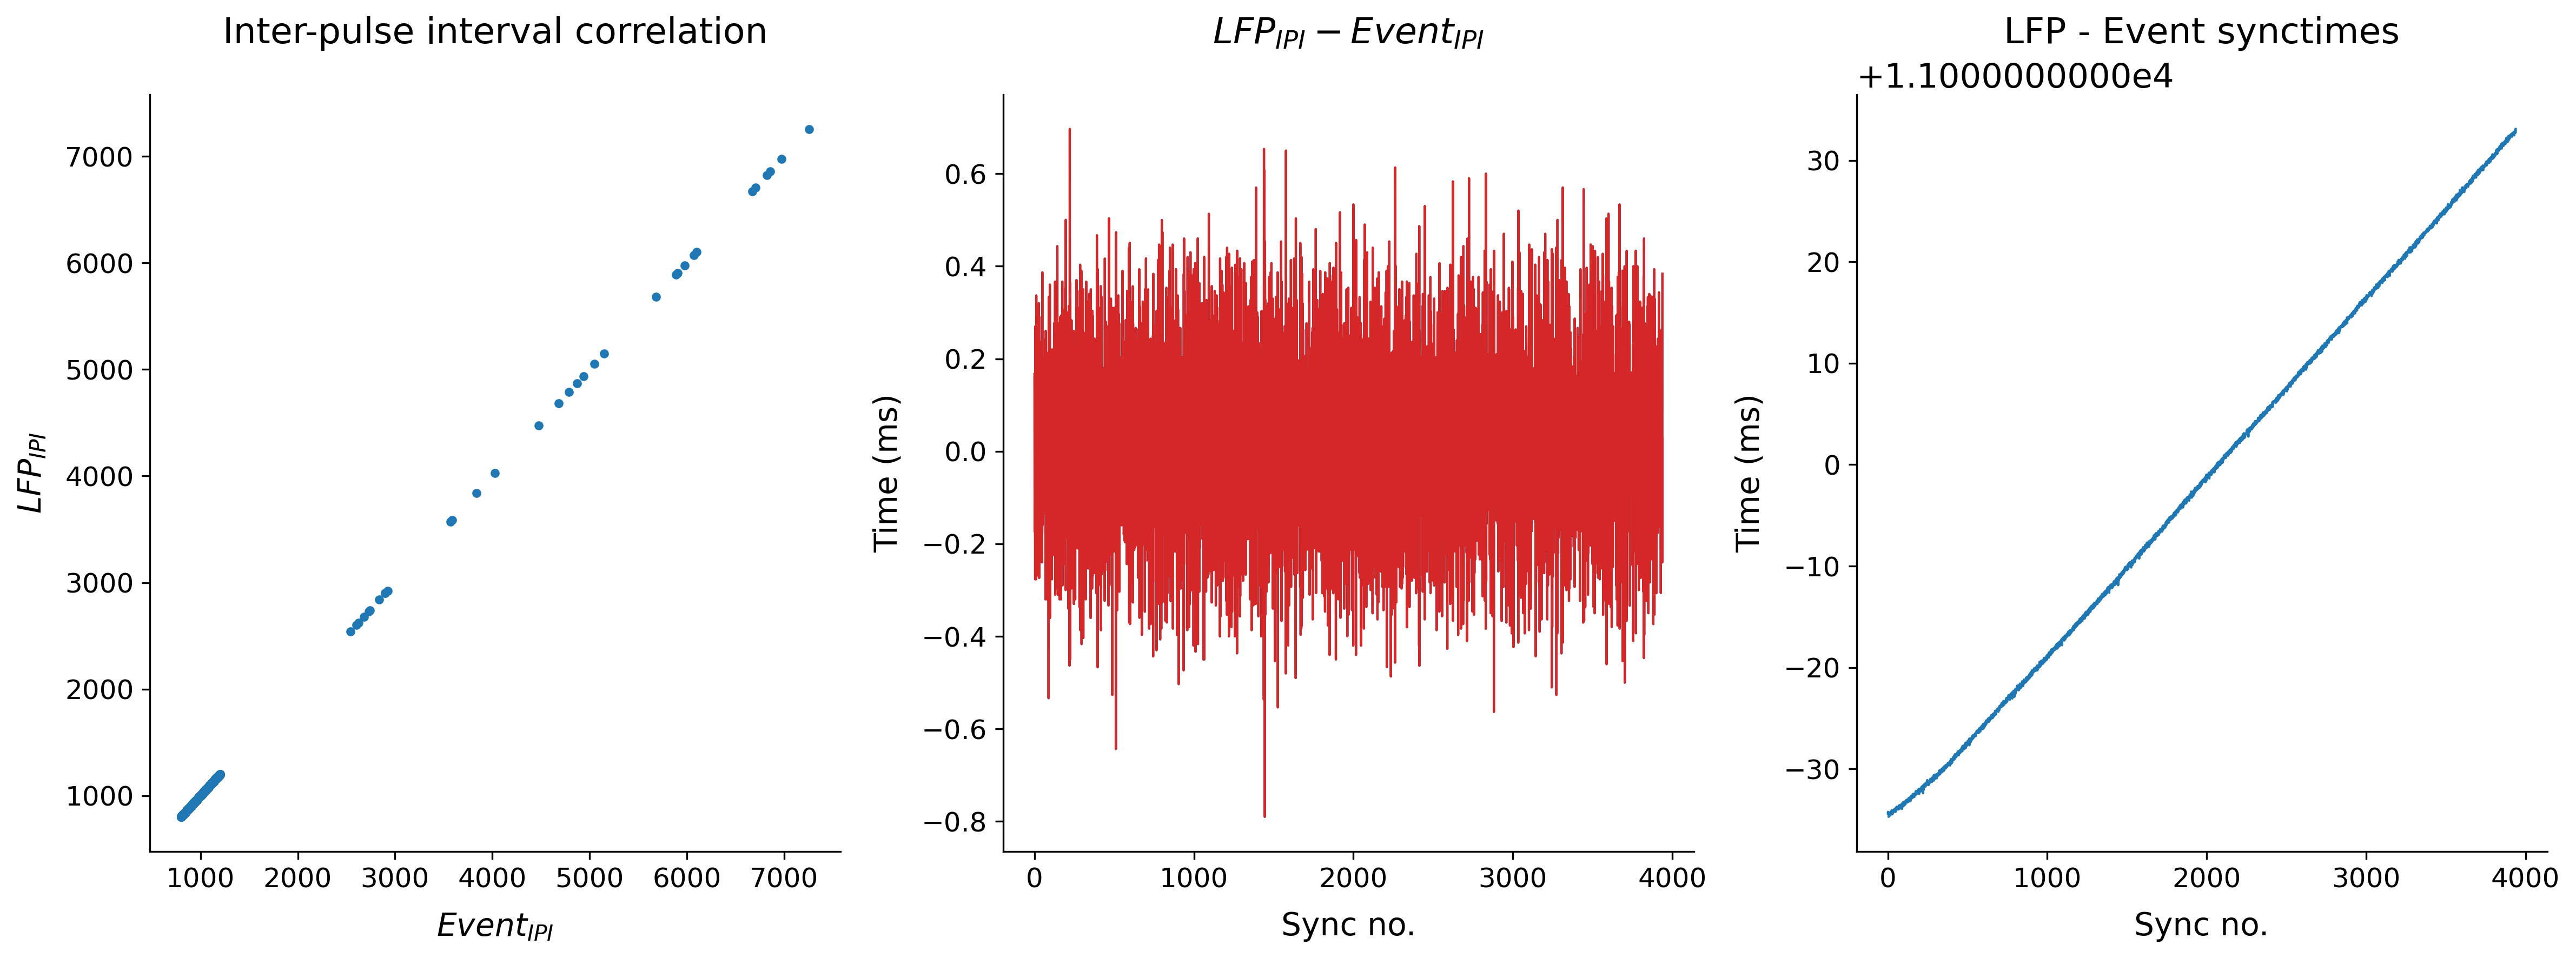

In [5]:
# Perform the alignment.
alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                             lfp_synctimes_adj)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))

# events.to_csv('./outputs/csv/events_all_adj.csv')
events.loc[events.key == 'syncPulse'].to_csv('./outputs/csv/events_all_adj_synctimes.csv')

# cjm addition
events['time'] = (events['time'] - events.at[0, 'time'])

plot_flag = 1    
if (plot_flag):

    # How did our alignment go?
    print('{} event sync pulses'.format(len(event_synctimes_adj)))
    print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
    print('\n--------------------\nAlignment parameters\n--------------------')
    for k, v in alignment.items():
        print('{}: {}'.format(k, v))

    plt.close()
    fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
    ax = np.ravel(ax)

    min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
    start = 0
    stop = None

    i = 0
    ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
    ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

    i = 1
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

    i = 2
    ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

    for i in range(len(ax)):
        ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
    fig.tight_layout()    

    event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
    event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                                  if x<len(lfp_timestamps)])).astype(np.int64)
    event_pulse_startinds_train = np.zeros(len(lfp_timestamps))
    event_pulse_startinds_train[event_pulse_inds] = 1

    fig, ax = plot_trace2(TTL_up, spike_dat=event_pulse_startinds_train,
                          start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)


## Format events and spikes

In [6]:
proc_events = True
proc_spikes = True
proj_dir = '/home1/cjmac/projects/time_cells'
subj_sess = 'U540_ses0'
run_all = True
save_output = True
overwrite = True
verbose = True

start_time = time()
warnings.filterwarnings('ignore')

print(subj_sess)
if proc_events:
    # Load events and event times.
    print('Processing events data.', end='\n\n')
    events = events_preproc.format_events(events=events,
                                          noisy_trials=[],
                                          remove_incomplete_trials=True,
                                          remove_noisy_trials=False,
                                          remove_paused_trials=False,
                                          overwrite=overwrite,
                                          save_output=save_output,
                                          proj_dir=proj_dir,
                                          verbose=verbose)

    events = events_proc.load_events(subj_sess,
                                     proj_dir=proj_dir,
                                     overwrite=overwrite,
                                     verbose=verbose,
                                     run_all=run_all)

    if save_output:
        events_proc.save_events(events,
                                overwrite=overwrite,
                                verbose=verbose)

U540_ses0
Processing events data.

Processing trial 1 and game state Delay
Processing trial 1 and game state ReturnToBase
Processing trial 2 and game state Delay
Processing trial 2 and game state ReturnToBase
Processing trial 3 and game state Delay
Processing trial 3 and game state ReturnToBase
Processing trial 4 and game state Delay
Processing trial 4 and game state ReturnToBase
Processing trial 5 and game state Delay
Processing trial 5 and game state ReturnToBase
Processing trial 6 and game state Delay
Processing trial 6 and game state ReturnToBase
Processing trial 7 and game state Delay
Processing trial 7 and game state ReturnToBase
Processing trial 8 and game state Delay
Processing trial 8 and game state ReturnToBase
Processing trial 9 and game state Delay
Processing trial 9 and game state ReturnToBase
Processing trial 10 and game state Delay
Processing trial 10 and game state ReturnToBase
Processing trial 11 and game state Delay
Processing trial 11 and game state ReturnToBase
Proc

KeyError: 'nearestItemPositionX'

In [ ]:
if proc_spikes:
    # Load spikes.
    print('Processing spikes data.', end='\n\n')
    spikes = spike_preproc.format_spikes(subj_sess,
                                         conv_factor='infer',
                                         fr_thresh=0.1,
                                         overwrite=True,
                                         save_output=True,
                                         split_files=True,
                                         verbose=verbose)

# warnings.resetwarnings()
# print('Done in {:.2f} s'.format(time() - start_time))

savefile = False
overwrite = False

event_spikes = time_bin_analysis.load_event_spikes(subj_sess, overwrite=overwrite)
if savefile:
    time_bin_analysis.save_event_spikes(event_spikes, overwrite=overwrite)

savefile = True
overwrite = True

event_spikes = time_bin_analysis.load_event_spikes(subj_sess, overwrite=overwrite)
if savefile:
    time_bin_analysis.save_event_spikes(event_spikes, overwrite=overwrite)

In [ ]:
def model_unit_fr_parallel(subj_sess_neuron):
    import sys
    import os
    from time import sleep
    import numpy as np
    sys.path.append('/home1/cjmac/code/projects')
    from time_cells.time_bin_analysis import model_unit_fr
    # Take a nap.
    if False:
        sleep_secs = int(1800 * np.random.rand())
        sleep(sleep_secs)
    try:
        subj_sess, chan, unit = subj_sess_neuron.split('-')
        neuron = '{}-{}'.format(chan, unit)
        output = model_unit_fr(subj_sess,
                               neuron,
                               model='ols',
                               n_perm=1000,
                               overwrite=True,
                               save_output=True)
    except:
        err = sys.exc_info()
        errf = '/home1/cjmac/logs/TryExceptError-model_unit_fr_parallel-{}'.format(subj_sess_neuron)
        os.system('touch {}'.format(errf))
        with open(errf, 'w') as f:
            f.write(str(err) + '\n')
    
    return None

# from importlib import reload
# flag_reload = 1
# if flag_reload:
#     reload( time_bin_analysis )

start_time = time()

# Load event_spikes and get the names of each neuron.
proj_dir = '/home1/cjmac/projects/time_cells'

# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
sessions = np.delete(sessions, 0)
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

subj_sess_neurons = []
for subj_sess in sessions:
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    for neuron in event_spikes.column_map['neurons']:
        subj_sess_neuron = '{}-{}'.format(subj_sess, neuron)
        #output_f = op.join(proj_dir, 'analysis', 'behav_glms', '{}-glm_results.pkl'.format(subj_sess_neuron))
        output_f = op.join(proj_dir, 'analysis', 'unit_to_behav', '{}-ols-time_bin-model_pairs.pkl'.format(subj_sess_neuron))
        print(output_f)
        if not op.exists(output_f):
            subj_sess_neurons.append(subj_sess_neuron)
    print('{} neurons'.format(len(subj_sess_neurons)))

# cjm change
subj_sess_neurons = ['U554_ses0-46-1']

# # cjm change
if False:
    subj_sess_neurons = [which_neuron for which_neuron in subj_sess_neurons if which_neuron in [ 'U554_ses0-46-1' ] ]

## Section to understand how OLS fitting was done in time_bin_analysis.py

In [ ]:
df = event_spikes.event_spikes.query("(gameState=='{}')".format('Retrieval')).copy()
neuron = '46-1'
keep_cols = ['trial', 'gameState', 'time_step', 'maze_region', 'head_direc', 'is_moving', 
             'base_in_view', 'gold_in_view', 'dig_performed', neuron]
df = df[keep_cols]
dummys = ['is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
df[dummys] = df[dummys].fillna(0)
df.to_csv('mdl_46-1.csv')
regress_trial = False
trial_term = ' + C(trial)' if regress_trial else ''
formulas = od([])
formulas['full']          = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subtime']  = "Q('{}') ~ 1                + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subplace'] = "Q('{}') ~ 1 + C(time_step)                  + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subhd']    = "Q('{}') ~ 1 + C(time_step) + C(maze_region)                 + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_submvmt']  = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc)             + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subbiv']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving                + dig_performed{}".format(neuron, trial_term)
formulas['full_subdig']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view                {}".format(neuron, trial_term)
mod_names = list(formulas.keys())
df2 = df[['trial', 'gameState', 'maze_region', '46-1']].to_csv('mdl_place_46-1.csv')

## Section to organize spiking data into a table to determin the # spikes per maze segment.

In [ ]:
all_neurons = event_spikes.column_map.get('neurons')
which_neuron = all_neurons[5]
keep_cols = ['trial', 'gameState', 'time_step', 'maze_region', 'head_direc', 'is_moving', 
             'base_in_view', 'gold_in_view', 'dig_performed', which_neuron]
rows = {'gameState':'Encoding'}
df = get_df_subset(event_spikes.event_spikes.copy(), columns = keep_cols, rows = rows)
df

# df.insert(4, 'duration', df['stop_time']-df['start_time'])
# df = df.drop(columns=['start_time', 'stop_time'])

# Let's print the first entries
# in all the groups formed.
df_group = df.groupby(['maze_region']).sum()
df_group.insert(3, 'rate', df_group[which_cell]/df_group['duration']*1000)
df_group

In [ ]:
if True:
    reload(time_bin_analysis)

# Parallel processing
for subj_sess_neuron in subj_sess_neurons:
    _start_time = time()
    print(subj_sess_neuron)
    _ = model_unit_fr_parallel(subj_sess_neuron)
    print('{:.1f}s'.format(time() - start_time))

print('Done in {:.1f}s')

In [ ]:
# subj_sess_neurons = subj_sess_neurons[23]
subj_sess_neurons

In [ ]:
# import pickle

with open('U554_ses0-46-1-ols-time_bin-model_pairs.pkl', 'rb') as f:
    data = pickle.load(f)

# %cd /home1/cjmac/projects/time_cells/analysis/unit_to_behav

In [ ]:
data